## FashionMNIST Networks 

<b>I implement several image-classifying neural network models for the FashionMNIST dataset. The dataset contains a collection of Zalando's article images. The code below loads the FashionMNIST dataset and shows some of the images.</b>

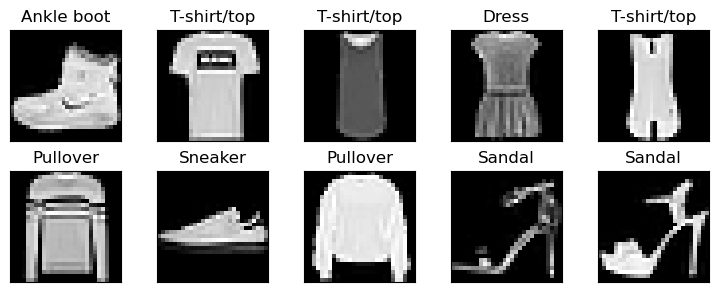

In [18]:
import torch
import torchvision
from util import *
        
# if you don't have FashionMNIST downloaded, run the code below twice to get rid of verbose outputs
fashion_tr = torchvision.datasets.FashionMNIST('~/.torchvision', train=True, download=True)
fashion_ts = torchvision.datasets.FashionMNIST('~/.torchvision', train=False, download=True)

# input values are normalized to [0, 1]
x_tr, y_tr = fashion_tr.data.float()/255, fashion_tr.targets
x_ts, y_ts = fashion_ts.data.float()/255, fashion_ts.targets

#print(x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape)

classes = fashion_tr.classes

plot_gallery([x_tr[i] for i in range(10)], 
             titles=[classes[y_tr[i]] for i in range(10)],
             xscale=1.5, yscale=1.5, nrow=2)

### Logistic Regression 

<b> Here I train a logistic regression model on the training set and report its accuracies on both the training and test sets.</b>

In [3]:
from sklearn.linear_model import LogisticRegression

# Reshaping our various test and training sets from
# (n, 28, 28), where n = # of examples, to (n, 28*28).

# So the nth row is a vector of 28*28 = 784 pixels belonging to the nth example.
x_tr_logistic, y_tr_logistic = x_tr.reshape(x_tr.shape[0],-1), y_tr
x_ts_logistic, y_ts_logistic = x_ts.reshape(x_ts.shape[0],-1), y_ts

#----- Define the multinomial logistic regression model -------#
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter = 10000, tol = 1e-4)

# fit the model to the training set
lr_model.fit(x_tr_logistic, y_tr_logistic)

# Mean accuracy of classifier on the given test data and labels
print(f"The LR model's training set data accuracy is: {lr_model.score(x_tr_logistic, y_tr_logistic)*100}%")
print(f"The LR model's test set data accuracy is: {lr_model.score(x_ts_logistic, y_ts_logistic)*100}%")

The LR model's training set data accuracy is: 88.105%
The LR model's test set data accuracy is: 84.41%


### Multilayer Perceptrons 

<b>For training an MLP, we flatten each image to a vector, and convert the labels to their one-hot encodings.</b>

In [4]:
from sklearn.model_selection import train_test_split

# onehot-encode a list of integer labels
def int2onehot(y):
    onehot = torch.zeros(len(y), y.max()+1)
    onehot[torch.arange(len(y)), y] = 1
    return onehot.long()

def vec(x):
    return x.reshape(x.shape[0], -1)

x_tr_mlp, y_tr_mlp = vec(x_tr), int2onehot(y_tr)
x_ts_mlp, y_ts_mlp = vec(x_ts), int2onehot(y_ts)

<b> We consider training a two-hidden-layer MLP with 100 sigmoid units for each hidden layer, and 10 output units:
    
\begin{align*}
    f(\mathbf{x}; W_{1}, W_{2}, W_{3}, b_{1}, b_{2}, b_{3}) 
    = 
    \sigma(W_{3} \sigma(W_{2} \sigma(W_{1} \mathbf{x} + b_{1}) + b_{2}) + b_{3}),
\end{align*}
    
where each 
$\mathbf{x} \in \mathbf{R}^{d}$ is the vector representation of a digit image, 
$W_{1} \in \mathbf{R}^{100 \times d}$,
$W_{2} \in \mathbf{R}^{100 \times 100}$,  
$W_{3} \in \mathbf{R}^{10 \times 100}$ are the weight matrices, 
$b_{1} \in \mathbf{R}^{100}$ and $b_{2} \in \mathbf{R}^{10}$ are the biases, and 
$\sigma(u)$ applies the sigmoid function to each component of a vector $u$.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class FashionMLP(nn.Module):
    def __init__(self, init='rand'):
        '''
        Initialize neural network parameters.
        
        Parameters
        ----------
        init: either 'zero' (all parameters are 0) or 'rand' (each parameter is uniformly sampled from [-0.5, 0.5])
        '''
        super().__init__()
        
        d = 28*28
        
        # Chaining together our NN layers in a sequential object
        self.MLP = nn.Sequential(nn.Linear(d,100),
                                 nn.Sigmoid(),
                                 nn.Linear(100,100),
                                 nn.Sigmoid(),
                                 nn.Linear(100,10),
                                 nn.Sigmoid())
        
        if init == 'zero': # all parameters initialised to 0
            #  nn.Parameter makes the parameters accessible via self.parameters()
            self.MLP[0].weight = nn.Parameter(torch.zeros(100, d))
            self.MLP[0].bias = nn.Parameter(torch.zeros(100))
            self.MLP[2].weight= nn.Parameter(torch.zeros(100, 100))
            self.MLP[2].bias = nn.Parameter(torch.zeros(100))
            self.MLP[4].weight = nn.Parameter(torch.zeros(10, 100))
            self.MLP[4].bias = nn.Parameter(torch.zeros(10))
            
        elif init == 'rand': # all parameters randomly drawn from U[-0.5, 0.5] 
            
            # We are updating the parameters
            # of our MLP in place, turning gradient_tracking off
            # to ensure this in-place operation isn't tracked for gradient
            # computations
            with torch.no_grad():
                self.MLP[0].weight.uniform_(-0.5,0.5)
                self.MLP[0].bias.uniform_(-0.5,0.5)
                self.MLP[2].weight.uniform_(-0.5,0.5)
                self.MLP[2].bias.uniform_(-0.5,0.5)
                self.MLP[4].weight.uniform_(-0.5,0.5)
                self.MLP[4].bias.uniform_(-0.5,0.5)
            
        else:
            raise BaseException('Unsupported weight initialization method!')

        
    def forward(self, x):
        '''
        Compute the outputs for given inputs.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        
        Returns
        -------
        o: a tensor of shape (n_samples, 10) containing the class scores
        '''

        return self.MLP(x)
    
    def predict(self, x):
        '''
        Predict the class indices for the input examples.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        
        Returns
        -------
        l: a tensor of shape (n_samples,) consisting of class indices
        '''
        # We forward pass through the NN
        # which outputs 10 numbers between (0,1)
        # We take the maximum digit to be the one-hot-encoded solution/estimated class
        o = self(x) # the same as self.forward(x)
        l = torch.max(o, 1)[1]
        #torch.max(o, 1)[0] are the maximum values in each example
        #torch.max(o, 1)[1] are the indices/classes which are maximum for each example
        return l
            
    def score(self, x, y):
        '''
        Compute the model's accuracy on the given dataset.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 784)
        y: a tensor of shape (n_samples, 10) containing the one-hot encodings
        '''
        pred_cls = self.predict(x)
        true_cls = torch.max(y, 1)[1]
        return (pred_cls == true_cls).sum().float().item() / len(y)

<b> We study the effect of initialization, learning rates, and batch sizes when training the above MLP by minimizing the following quadratic loss
\begin{align*}
  R_{n}({\bf w})
  = \frac{1}{n} \sum_{i=1}^{n} ||f(\mathbf{x}_{i}; {\bf w}) - y_{i}||_{2}^{2},
\end{align*}
where $f({\bf x}, {\bf w})$ is the MLP with ${\bf w}$ as the parameters and ${\bf x}$ as the input, and
$(\mathbf{x}_{1}, y_{1}), \ldots (\mathbf{x}_{n}, y_{n}) \in \mathbf{R}^{d} \times
\mathbf{R}^{10}$ is the training set.</b>

Specifically, I train the MLP above by running Stochastic Gradient Descent for 100 epochs (one epoch means one pass through the training data) using all combinations of the following hyperparameter values:</b>
* initializaton: `zero`, `rand`
* learning rate: 0.001, 0.01, 0.1,  1
* batch size: 100, 60000

<b>I also compute the training and test accuracies for all these 16 models, and comment the effect of initialization, learning rate and batch size.</b>

In [9]:
def mseloss(o, y):
    '''
    Compute the MSE loss defined in the question.
    
    Parameters
    ----------
    o: a tensor of shape (n_samples, 10) containing the class scores
    y: a tensor of shape (n_samples, 10) containing the one-hot encodings
    
    Returns
    -------
    l: the MSE loss
    '''
    # Task:  compute the loss - make sure your code computes exactly the same loss
    n_samples, n_classes = o.shape
    return ((o - y)**2).sum()/n_samples

def train(net, x, y, lossfunc, lr=0.1, momentum=0, batch_size=600, nepochs=10):
    # check what device the net parameters are on
    device = next(net.parameters()).device 
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    # training loop
    dataloader = DataLoader(DatasetWrapper(x, y), batch_size=batch_size, shuffle=True)
    loop = tqdm(range(nepochs), ncols=110)
    for i in loop: # for each epoch
        t0 = time()
        
        # Task: fill in your training code below and compute epoch_loss (the average loss on all batches in a epoch)
        epoch_loss = 0
        n_batches = 0
        for (x_batch, y_batch) in dataloader: # for each mini-batch
            
            # Move mini batches to device (GPU if one exists)
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Forward pass through the NN
            pred = net(x_batch)
            loss = lossfunc(pred, y_batch)
            # Calculate gradients of parameters w/ backprop
            # loss.backward() adds the gradients to whatever is already stored, rather than replacing them
            loss.backward()
            # We can use the step method from our optimizer
            # to take a forward step, instead of manually updating each parameter.
            optimizer.step()
            # Zero the gradients in weights/biases before next mini_batch
            optimizer.zero_grad()
            
            # Add loss to epoch loss to eventually compute
            # an average epoch loss - detach from computational graph to reduce RAM
            epoch_loss += loss.detach()
            n_batches += 1

        # Average epoch loss
        epoch_loss = epoch_loss/n_batches

        # evaluate network performance
        acc = test(net, x, y, batch_size=batch_size)

        # show training progress
        loop.set_postfix(loss="%5.5f" % (epoch_loss),
                         train_acc="%.2f%%" % (100*acc))

# try running test(FashionMLP(), x_ts_mlp, y_ts_mlp, showerrors=True) to see what the code does
def test(net, x, y, batch_size=600, showerrors=False):
    with torch.no_grad(): # disable automatic gradient computation for efficiency
        device = next(net.parameters()).device

        pred_cls = []
        # make predictions on mini-batches  
        dataloader = DataLoader(DatasetWrapper(x), batch_size=batch_size, shuffle=False)
        for x_batch in dataloader:
            x_batch = x_batch.to(device)
            pred_cls.append(torch.max(net(x_batch), 1)[1].cpu())

        # compute accuracy
        pred_cls = torch.cat(pred_cls) # concat predictions on the mini-batches
        true_cls = torch.max(y, 1)[1].cpu()
        acc = (pred_cls == true_cls).sum().float() / len(y)

        # show errors if required
        if showerrors:
            idx_errors = (pred_cls != true_cls)

            x_errors = x[idx_errors][:10].cpu()
            y_pred = pred_cls[idx_errors][:10].cpu().numpy()
            y_true = true_cls[idx_errors][:10].cpu().numpy()
            #print(y_true)

            plot_gallery(x_errors.reshape(10,28,28),
                         titles=[classes[y_true[i]] + '\n->' + classes[y_pred[i]] for i in range(10)],
                         xscale=1.5, yscale=1.5, nrow=2)
        return acc        

In [10]:
torch.manual_seed(1) # for reproducibility
from util import *

# Boolean flag which decides if we want
# to retrain our model, or just load saved model
# weights and produce necessary outputs

# Please leave this as false to avoid retraining the 16 models
# Running this code block will output accuracies of loaded/trained models
RETRAIN = False

initialisations = ["rand","zero"]
learning_rates = [0.001, 0.01, 0.1, 1]
batch_sizes = [100, 60000]
lossfunc = mseloss

if RETRAIN:

    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )

    # Task: write your code to train the 16 models and compute their training and test accuracies
    model_i = 0

    for init in initialisations:
        for lr in learning_rates:
            for batch_size in batch_sizes:

                model_i += 1

                print(f"Model {model_i}: \n")
                print(f"lr = {lr}; batch_size = {batch_size}; init = {init}")

                net = FashionMLP(init = init).to(device)

                train(net, x_tr_mlp, y_tr_mlp, 
                      lossfunc, lr=lr, momentum=0, batch_size=batch_size, nepochs=100)

                # Moving the trained NN to cpu() to free memory for GPU
                net = net.cpu()

                # Save model
                torch.save(net.state_dict(), f"supplements/MLPstate_dict{model_i}.pth")

                # Mean accuracy of classifier on the given test data and labels
                print(f"TRAINING SET ACCURACY of MLP {model_i} (lr = {lr}; batch_size = {batch_size}; init = {init}): {net.score(x_tr_mlp, y_tr_mlp)*100}%")
                print(f"TEST SET ACCURACY of MLP {model_i} (lr = {lr}; batch_size = {batch_size}; init = {init}) on the test set: {net.score(x_ts_mlp, y_ts_mlp)*100}% \n")
                
else:

    #Tracking model number
    model_i = 0
    
    for init in initialisations:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                
                model_i += 1
                
                loaded_MLP = FashionMLP(init = init)
                loaded_MLP.load_state_dict(torch.load(f"supplements/MLPstate_dict{model_i}.pth"))
                # Mean accuracy of classifier on the given test data and labels
                print(f"TRAINING SET ACCURACY of MLP {model_i} (lr = {lr}; batch_size = {batch_size}; init = {init}): {loaded_MLP.score(x_tr_mlp, y_tr_mlp)*100}%")
                print(f"TEST SET ACCURACY of MLP {model_i} (lr = {lr}; batch_size = {batch_size}; init = {init}) on the test set: {loaded_MLP.score(x_ts_mlp, y_ts_mlp)*100}% \n")

TRAINING SET ACCURACY of MLP 1 (lr = 0.001; batch_size = 100; init = rand): 70.42333333333333%
TEST SET ACCURACY of MLP 1 (lr = 0.001; batch_size = 100; init = rand) on the test set: 69.88% 

TRAINING SET ACCURACY of MLP 2 (lr = 0.001; batch_size = 60000; init = rand): 10.156666666666666%
TEST SET ACCURACY of MLP 2 (lr = 0.001; batch_size = 60000; init = rand) on the test set: 10.15% 

TRAINING SET ACCURACY of MLP 3 (lr = 0.01; batch_size = 100; init = rand): 82.95333333333333%
TEST SET ACCURACY of MLP 3 (lr = 0.01; batch_size = 100; init = rand) on the test set: 81.67999999999999% 

TRAINING SET ACCURACY of MLP 4 (lr = 0.01; batch_size = 60000; init = rand): 14.746666666666666%
TEST SET ACCURACY of MLP 4 (lr = 0.01; batch_size = 60000; init = rand) on the test set: 13.98% 

TRAINING SET ACCURACY of MLP 5 (lr = 0.1; batch_size = 100; init = rand): 89.89666666666668%
TEST SET ACCURACY of MLP 5 (lr = 0.1; batch_size = 100; init = rand) on the test set: 86.98% 

TRAINING SET ACCURACY of M

Evidently, the MLPs whose weights were initialized to random numbers $\in [-0.5,0.5]$ performed a lot better than the models with weights initialized to zero. This was expected, given that initializing all weights in an MLP to zero means that the derivative with respect to the loss function is the same for every weight $w$ in every layer of the network. Thus, all weights have the same value in subsequent training epochs. This means that such a model never improves its classification performance given that hidden neurons are never different from one another.

It should be noted, however, that MLP 15 learned spuriously despite having all weights initialized to zero. This should not have happened in practice and $\textbf{is an outlier}$.

For the eight models that were trained with all weights initialized to random numbers $\in [-0.5,0.5]$, models with a batch size of 100 outperformed models with a batch size of 60000. We expect performing SGD with a smaller batch size to be more optimal than with a batch size equal to the entire training set $\textbf{if the smaller batch size is large enough to approximate the training set loss reasonably well}$. If this condition is fulfilled, then one is able to update the model parameters more frequently (with reasonable accuracy), and thus train a better model than with a batch size equal to the entire training set.

Finally, we observed improvements in both training set and test set accuracy for increased learning rates in the eight MLPs trained with 'random' weight initialisations.

Curiously, there were some MLPs that performed slightly better on the test set than the training set. This might have been due to numerical error.

### Convolution neural networks 

<b>For training a CNN, we use one-hot encodings of the labels as for the MLP, but we add a channel dimension to the data using the `unsqueeze` function, which will be convenient for performing convolutions.</b>

In [11]:
x_tr_cnn, y_tr_cnn = x_tr.unsqueeze(1), int2onehot(y_tr)
x_ts_cnn, y_ts_cnn = x_ts.unsqueeze(1), int2onehot(y_ts)

<b> We consider the following CNN:
The input layer is followed by the following layers:
a convolutional layer with 32 3x3 filters (stride 1) and ReLU activation,
a 2x2 max-pooling layer,
a fully connected layer with 100 neurons and ReLU activation,
and finally, a fully connected output layer with 10 neurons.
</b>


In [12]:
class FashionCNN(nn.Module):
    def __init__(self, feature_extract = False):
        super(FashionCNN, self).__init__()
        
        self.CNN = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, device = None, stride = 1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, stride = 2, padding=0, dilation=1),
                                 nn.Flatten(),
                                 nn.Linear(32*13*13, 100, bias = True, device = None),
                                 nn.ReLU(),
                                 nn.Linear(100, 10, bias = True, device = None)
                                 )

    def forward(self, xb):
        '''
        Compute the outputs for given inputs.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 1, 28, 28)
        
        Returns
        -------
        o: a tensor of shape (n_samples, 10) containing the class scores
        '''
        return self.CNN(xb)
    
    def predict(self, x):
        '''
        Predict the class indices for the input examples.

        Parameters
        ----------
        x: a tensor of shape (n_samples, 1, 28, 28)

        Returns
        -------
        l: a tensor of shape (n_samples,) consisting of class indices
        '''
        # We forward pass through the NN
        # which outputs 10 numbers between (0,1)
        # We take the maximum digit to be the one-hot-encoded solution/estimated class
        o = self(x) # the same as self.forward(x)
        l = torch.max(o, 1)[1]
        #torch.max(o, 1)[0] are the maximum values in each example
        #torch.max(o, 1)[1] are the indices/classes which are maximum for each example
        return l

    def score(self, x, y):
        '''
        Compute the model's accuracy on the given dataset.
        
        Parameters
        ----------
        x: a tensor of shape (n_samples, 1, 28, 28)
        y: a tensor of shape (n_samples, 10) containing the one-hot encodings
        '''
        pred_cls = self.predict(x)
        true_cls = torch.max(y, 1)[1]
        return (pred_cls == true_cls).sum().float().item() / len(y)

<b>
Here I train a FashionCNN using an appropriate loss function and appropriate hyperparameters (e.g., the learning rate, the number of epochs, the batch size). I briefly describe how I make these decisions and report the test set accuracy of my final CNN and display 10 of its errors on the test set using the `test` function provided above.</b>

In [13]:
# Training 12 models and selecting the one that performs best on the test set

torch.manual_seed(1) # for reproducibility
from util import *

# Boolean flag which decides if we want
# to retrain our model, or just load saved model
# weights and produce necessary outputs

# Please leave this as false to avoid retraining models.
# Executing the code block will do nothing if we leave this as false.
# Otherwise, models will be retrained.
RETRAIN = False

## Note to marker: Our model was trained on GPU and loaded on CPU later
if RETRAIN:
    
    device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
    )
    print(f"Using {device} device. \n")
    
    # Training parameters
    epochs = [50, 100]
    # Higher learning rates performed badly on smaller subsets of the training set
    learning_rates = [0.01, 0.1] 
    batch_sizes = [100, 1000, 10000]
    lossfunc = mseloss

    # Task: write your code to train the 16 models and compute their training and test accuracies
    model_i = 0

    for nepochs in epochs:
        for lr in learning_rates:
            for batch_size in batch_sizes:

                model_i += 1

                print(f"Model {model_i}: \n")
                print(f"(lr = {lr}; batch_size = {batch_size}; nepochs = {nepochs})")

                net = FashionCNN().to(device)

                train(net, x_tr_cnn, y_tr_cnn, 
                      lossfunc, lr=lr, momentum=0, batch_size=batch_size, nepochs=nepochs)

                # Mean accuracy of classifier on the given test data and labels
                print(f"TRAINING SET ACCURACY of CNN {model_i} (lr = {lr}; batch_size = {batch_size}; nepochs = {nepochs}): {net.score(x_tr_cnn.to(device), y_tr_cnn.to(device))*100}%")
                print(f"TEST SET ACCURACY of CNN {model_i} (lr = {lr}; batch_size = {batch_size}; nepochs = {nepochs}): {net.score(x_ts_cnn.to(device), y_ts_cnn.to(device))*100}% \n")

                ## SAVED ON GPU, LOADED ON CPU/GPU later
                ## Note for marker: You can load these saved CNNs to see their test accuracies
                ## if you want. I only print out the accuracy of the best model as asked.
                torch.save(net.state_dict(), f"supplements/CNNstate_dict{model_i}.pth")

                # Delete the trained NN from GPU memory
                del net
                torch.cuda.empty_cache()

TRAINING SET ACCURACY of CNN (lr = 0.1; batch_size = 100; nepochs = 50): 98.31666666666666%
TEST SET ACCURACY of CNN (lr = 0.1; batch_size = 100; nepochs = 50): 91.82000000000001% 



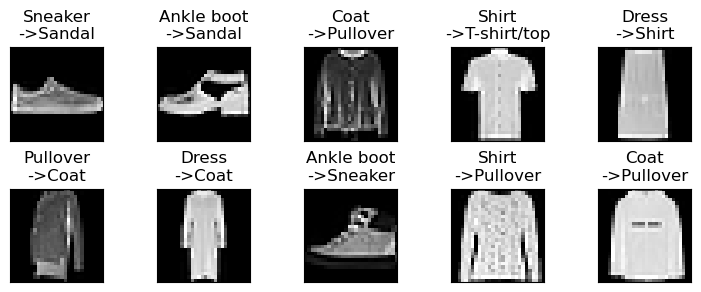

tensor(0.9182)

In [14]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#print(f"Using {device} device. \n")

# SAVED ON GPU, LOADED ON CPU/GPU - Loading our model that performed best on the test set
bestCNN = FashionCNN()
bestCNN.load_state_dict(torch.load(f"supplements/CNNstate_dict4.pth", map_location = device))
# Mean accuracy of classifier on the given test data and labels
print(f"TRAINING SET ACCURACY of CNN (lr = 0.1; batch_size = 100; nepochs = 50): {bestCNN.score(x_tr_cnn, y_tr_cnn)*100}%")
print(f"TEST SET ACCURACY of CNN (lr = 0.1; batch_size = 100; nepochs = 50): {bestCNN.score(x_ts_cnn, y_ts_cnn)*100}% \n")

# Displaying 10 of our classifiers errors on the test set using the test function provided above.
test(bestCNN, x_ts_cnn, y_ts_cnn, showerrors=True) 

We trained a FashionCNN using a learning rate of 0.1, a batch size of 100 and with 50 training epochs. As seen above, it's training set accuracy was 98.3% while its test set accuracy was 91.8%. Clearly, it was a better model than the previously trained Logistic Regression model as well as the 16 trained MLPs. 

To arrive at these parameter values, first I trained multiple CNNs using a small subset of the training data - namely, 2000 training images. I noticed that learning rates of 1 and above produced very bad results, so I opted not to use such learning rates for my formal training procedure.

In my formal training procedure, I trained 12 CNNs sweeping different combinations of the following parameter values: epochs = 50, 100; learning rate = 0.01, 0.1; batch size = 100, 1000, 10000. I trained them using a GPU on Google Colab - saving their state dictionaries. The reported model returned the highest test set accuracy. 

If I had more time/infinite computing power, I would have swept lower learning rates, as well as higher epochs and batch sizes to see if I could produce a better model. That said, the resulting model performed reasonably well. As seen above, some of the errors it made during classifcation were forgivable/understandable errors.

<b> For the first test image, I will retrieve its nearest 5 training examples in the
learned feature space (the learned features are the inputs to the output
layer, that is, the output values of the last hidden layer).
Do they represent the same kind of clothes as the test image? I will use a suitable distance measure to answer this question.</b>

The actual class label of the first test image (below) is: Ankle boot.


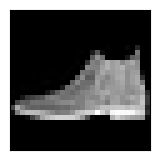

5 nearest training examples to the first test image in the learnt feature space:


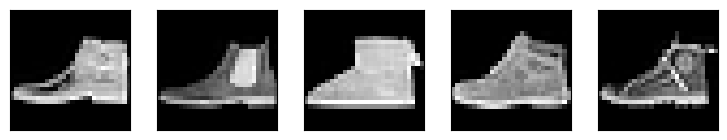

In [17]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import get_graph_node_names

return_nodes = {
    # node_name: user-specified key for output dict
    'CNN.5': 'last_HiddenLayer',
}

# Creating a feature_extractor for our bestCNN model
feature_extractor = create_feature_extractor(bestCNN, return_nodes=return_nodes)

# Generating a 60,000 x 100 matrix
# w/ training images in the 'learnt feature space' on the rows
learnt_features = feature_extractor(x_tr_cnn)
learnt_feature_matrix = learnt_features['last_HiddenLayer']

# 1 x 100 single first test image, projected onto the 100-dimensional
# feature space
testimg_featurespace = feature_extractor(x_ts_cnn[0].unsqueeze(0))
projected_testimg = testimg_featurespace['last_HiddenLayer']

# Let M = learnt_feature_matrix - projected_testimg w/ shape (n_examples,100)
M = learnt_feature_matrix - projected_testimg

# L2 norm of th difference between all training examples and the test
# image on the rows of this matrix
l2norm_diffs = (M**2).sum(dim = 1)

# Selecting indices corresponding to lowest 5 l2norm_diffs
# to get 5 nearest training images in the learnt feature space
indices_5nearneighbrs = torch.topk(-l2norm_diffs,5)[1]

print(f"The actual class label of the first test image (below) is: {classes[y_ts[0]]}.")

plot_gallery(x_ts_cnn[0].unsqueeze(0).reshape(1,28,28),
             xscale=1.7, yscale=1.7, nrow=1)

print(f"5 nearest training examples to the first test image in the learnt feature space:")

plot_gallery(x_tr_cnn[indices_5nearneighbrs].reshape(5,28,28),
             xscale=1.5, yscale=1.5, nrow=1)


Evidently, the 5 nearest training examples to the first test image in the learnt feature space represent the same kind of clothing object (shoe) as the test image.